In [1]:
import networkit as nk 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
import networkx as nx 

In [3]:
import os 

# General Callgraphs: Scale-Free Exploration 

### Use the largest weakly connected component in place of the whole callgraph

In [4]:
callgraphMetrics = {} 
callgraphs       = {}
for file in os.listdir('/logs'):
    filepath     = '/'.join(['/logs', file])
    if os.path.isfile(filepath): 
        if 'TrilinosCG' in file: 
            file_pd                    = pd.read_csv(filepath)
            callgraphMetrics[filepath] = file_pd 
        if 'TrilinosGR' in file: 
            file_nx              = nx.read_edgelist(filepath, create_using=nx.DiGraph())
#             file_nx = max(nx.weakly_connected_components(file_nx),key=len)[0]
            file_nk              = nk.nxadapter.nx2nk(file_nx)
            wcc                  = nk.components.WeaklyConnectedComponents(file_nk)
            wcc.run()
            components           = wcc.getComponents()
            largst_wcc_l         = [x for x in components if len(x) == max(len(y) for y in components)]
            largst_wcc           = largst_wcc_l[0]
            sample_gr_lwcc       = nk.graphtools.subgraphFromNodes(file_nk, largst_wcc)
            callgraphs[filepath] = sample_gr_lwcc
            

why read using networkx and then convert to networkit thereby adding extra conversion-time, you ask? Because apparently networkit has no easy way of reading directed graphs. 

In [5]:
list(callgraphs.keys())[:5]

['/logs/TrilinosGR.TabOne',
 '/logs/TrilinosGR1300.TabOne',
 '/logs/TrilinosGR1301.TabOne',
 '/logs/TrilinosGR1320.TabOne',
 '/logs/TrilinosGRApr16th2015.TabOne']

In [6]:
nk.overview(list(callgraphs.values())[0])

Network Properties:
nodes, edges			21020, 101875
directed?			True
weighted?			False
isolated nodes			2983
self-loops			258
density				0.000230
min/max/avg degree		0, 294, 4.846575
degree assortativity		0.058990
number of connected components	20979
size of largest component	7 (0.03 %)


In [7]:
len(callgraphs.values())

41

In [8]:
list(callgraphMetrics.values())[0].head()

,Unnamed: 0,Name,FanIn,FanOut,IsIsolated,AvgShortestPath,Closeness,Betweenness,Eccentricity_R,Eccentricity_N
0,0,_ZNK6shards11ArrayDimTag9to_stringB5cxx11Eii,0,9,False,1975.4,0.000506,0.0,2,15
1,1,_ZN6shards12array_traits11check_rangeEii,2,10,False,2116.5,0.000472,16.0,1,9
2,2,_ZNSt7__cxx1119basic_ostringstreamIcSt11char_t...,1138,0,False,inf,0.000000,0.0,0,2
3,3,_ZNSolsEi,1014,0,False,inf,0.000000,0.0,0,3
4,4,_ZNSt7__cxx1112basic_stringIcSt11char_traitsIc...,608,0,False,inf,0.000000,0.0,0,4


Note that for every CG and GR file, there exists a corresponding NM file. Thus, even though the C++ identifiers are kept mangled, one can easily 
unmangle them by piping the contents of the file through c++filt. 

Moreover, if the average shortest path of a given node is infinite, this should mean that  
there exists at least one node in the network that the node in question is not connected to. If, in addition, the node's fan-out is zero, then all paths end at the node, and thus is betweenness is zero. For our problem domain, nodes are functions and for a function to be such an end-point, the function would have to be a built-in function.  We drop such built-in functions.

In [9]:
sample_pd = list(callgraphMetrics.values())[0][['FanIn', 'FanOut', 'AvgShortestPath', 'Betweenness', 'Eccentricity_R']]

In [10]:
sample_gr = list(callgraphs.values())[0] 

In [11]:
import math 

In [12]:
ans   = True 
count = 0
counterex = []
for i in sample_pd.index: 
    if sample_pd.AvgShortestPath[i] == math.inf: 
        if sample_pd.FanOut[i] == 0: 
            if sample_pd.Betweenness[i] != 0:
                ans = False 
                count += 1 
                counterex.append((i, sample_pd.FanOut[i]))
print(ans) 
print(count)
print(counterex)

True
0
[]


Our condition holds, and we proceed to drop

In [13]:
sample_pd = sample_pd.drop(
              sample_pd[
                  (sample_pd.AvgShortestPath == math.inf) & 
                  (sample_pd.FanOut == 0) 
              ].index 
            )

In [14]:
sample_pd = sample_pd.drop(sample_pd[sample_pd.AvgShortestPath == math.inf].index)

### Fan-In & Fan-Out

#### single version

In [15]:
sample_pd_fanin  = sample_pd.FanIn.value_counts().rename_axis('unique_fanins').reset_index(name='counts')
sample_pd_fanout = sample_pd.FanOut.value_counts().rename_axis('unique_fanouts').reset_index(name='counts')

In [16]:
sample_pd_fanin['probs'] = sample_pd_fanin['counts'] / sample_pd_fanin['counts'].sum()
sample_pd_fanout['probs'] = sample_pd_fanout['counts'] / sample_pd_fanout['counts'].sum()

In [17]:
sample_pd_fanin.head()

,unique_fanins,counts,probs
0,1,7641,0.418960
1,0,6866,0.376467
2,2,2016,0.110538
3,3,486,0.026648
4,4,366,0.020068


Text(0, 0.5, 'P(FanIn)')

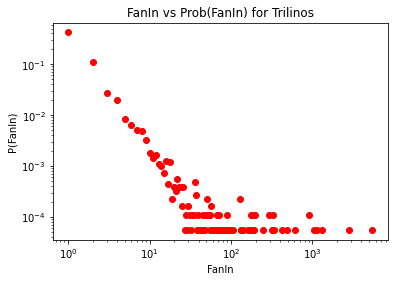

In [18]:
fig = plt.figure() 
ax = plt.gca()
ax.scatter(sample_pd_fanin.unique_fanins, sample_pd_fanin.probs, color='r')
# ax.plot(np.unique(sample_pd_fanin.unique_fanins), 
#                 np.poly1d(np.polyfit(sample_pd_fanin.unique_fanins, 
#                                      sample_pd_fanin.probs, 1))
#         (np.unique(sample_pd_fanin.unique_fanins)))
ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('FanIn vs Prob(FanIn) for Trilinos')
ax.set_xlabel('FanIn') 
ax.set_ylabel('P(FanIn)')

Text(0, 0.5, 'P(FanOut)')

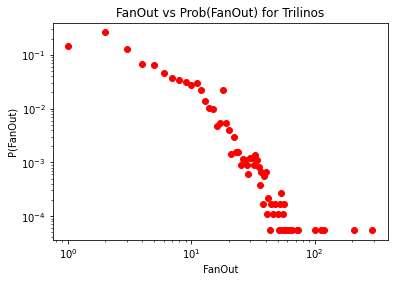

In [19]:
fig = plt.figure() 
ax = plt.gca()
ax.scatter(sample_pd_fanout.unique_fanouts, sample_pd_fanout.probs, color='r')
# ax.plot(np.unique(np.log(sample_pd_fanout.unique_fanouts)), np.poly1d(np.polyfit(np.log(sample_pd_fanout.unique_fanouts), np.log(sample_pd_fanout.probs), 1))(np.unique(np.log(sample_pd_fanout.unique_fanouts))), ':')
ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('FanOut vs Prob(FanOut) for Trilinos')
ax.set_xlabel('FanOut') 
ax.set_ylabel('P(FanOut)')

Since the probabilities P(FanIn) and P(FanOut) seem to be in a linear relationship with negative slope to FanIn and FanOut values respectively, it follows that Trilinos' overall callgraph (for this version) seems to be small-world network.

# General Callgraphs: Small-World Exploration

A *Small-World Network* is a simple connected graph G exhibiting two properties:
     - **Large Clustering Coefficient**: Each vertex of G is linked to a relatively well-connected set of neighboring vertices, resulting in a large value for the clustering coefficient C(G). 
     - **Small Characteristic Path Length** The presence of short-cut connections between some vertices results in a small characteristic path length L(G).

In [20]:
sample_pd.size 

91190

In [21]:
sample_pd.AvgShortestPath.sum() / sample_pd.size  

1135.164105395523

In [22]:
ed = nk.distance.EffectiveDiameter(nk.graphtools.toUndirected(sample_gr))
ed.run()
ed.getEffectiveDiameter()

4.673644148430067

**N.B: It is weird that average shortest path should be so large when the effective diameter of the graph is so small. Doesn't it follow that the diameter of a graph is always greater than or equal to its average shortest path? This makes me think that average shortest path calculation (which is currently being calculated as the reciprocal of the closeness centrality metric) is most likely wrong!!!**

In [23]:
sample_pd.columns

Index(['FanIn', 'FanOut', 'AvgShortestPath', 'Betweenness', 'Eccentricity_R'], dtype='object')

In [24]:
sample_pd.Eccentricity_R.mean()

3.253591402566071

If the eccentricity of a given node represents its maximum shortest path from the node to any other node in the network, then the average eccentricity in a network should always be greater than its all-pairs average shortest path. Consequently, if the average eccentricity of a network is relatively small, then its average shortest path is relatively small also, and the second property of small-world networks can be verified by confirming that this average eccentricity stays small as the network evolves: 

In [25]:
avg_eccentricities = {}
for f, f_pd in callgraphMetrics.items(): 
    f_pd = f_pd.drop(
              f_pd[
                  (f_pd.AvgShortestPath == math.inf) & 
                  (f_pd.FanOut == 0) 
              ].index 
            )
    avg_eccentricities[f] = f_pd.Eccentricity_R.mean() 

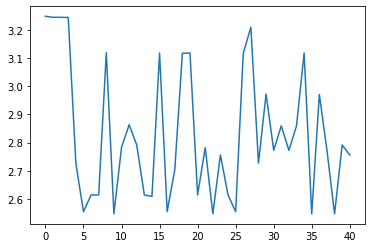

In [26]:
plt.plot(avg_eccentricities.values())

In [27]:
sum(avg_eccentricities.values()) / len(avg_eccentricities.values())

2.8311943655225895

In [28]:
gr_sizes = {} 
for f, f_gr in callgraphs.items(): 
    num_edges = f_gr.numberOfEdges() 
    gr_sizes[f] = num_edges 

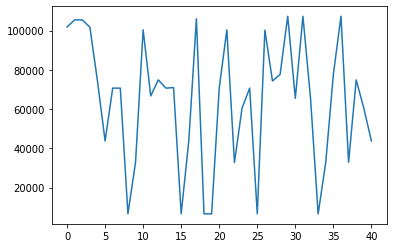

In [29]:
plt.plot(gr_sizes.values())

In [30]:
sum(gr_sizes.values()) / len(gr_sizes.values())

64471.829268292684

Clearly these eccentricities, staying between 2.5 and 3.3, are relatively small compared to the number of edges in each network (between 10k and 110k). Thus, we can conclude that, on average, it takes a maximum of around 3 hops for any function in the callgraph (of around 64472 nodes on average) to call any other function in the Trilinos---a characteristic which might have implications relating to propagation of bugs in the software, for example.

In [31]:
nk.globals.clustering(sample_gr)

0.07504560062538

In [32]:
sample_gr_nx = nk.nxadapter.nk2nx(sample_gr)
nx.average_clustering(sample_gr_nx)

0.0959695769823756

**Are 7% or 9% small values of the clustering coefficient?**

### TODO

   * #### Generate Barabasi albert model with characteristics almost similar to above graphs 
   * #### Generate Erdos-Renyi model with charactersitics almost similar to above graphs 
   * #### Generate Clustered-Networks with characteristics ''      "          "    " 

In [33]:
ba_gen = nk.generators.BarabasiAlbertGenerator(k=0, nMax=21020)

In [34]:
f_ba_gen = ba_gen.fit(sample_gr)
type(f_ba_gen)

networkit.generators.BarabasiAlbertGenerator

In [35]:
dir(nk.generators.BarabasiAlbertGenerator)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'fit',
 'generate']

In [36]:
help(nk.generators.BarabasiAlbertGenerator.generate)

Help on method_descriptor:

generate(...)
    Generates the graph.
    
    Returns:
    --------
    networkit.Graph



In [ ]:
sample_gr_BA_G = ba_gen.generate()
type(sample_gr_BA_G)

In [ ]:
nk.overview(sample_gr_BA_G)

In [ ]:
sample_gr_undr = nk.graphtools.toUndirected(sample_gr)

In [ ]:
nk.overview(sample_gr_undr)